In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
import pymc3 as pm

%matplotlib inline

In [25]:
senate = pd.read_csv('./data/senate.csv')

In [26]:
senate.head()

,created_at,id_str,reply_count,retweet_count,text,user,name,state,party,the_ratio
0,Sun May 21 19:26:26 +0000 2017,8.660000e+17,116.0,174.0,"Franni here. Since it's Al's birthday, and sin...",alfranken,Al Franken,New York,Democratic,0.666667
1,Tue May 16 01:44:44 +0000 2017,8.640000e+17,718.0,1248.0,This is profoundly troubling. Why would Presid...,alfranken,Al Franken,New York,Democratic,0.575321
2,Wed May 10 19:55:37 +0000 2017,8.620000e+17,218.0,1334.0,It couldn't be clearer: we need an independent...,alfranken,Al Franken,New York,Democratic,0.163418
3,Wed May 10 19:54:55 +0000 2017,8.620000e+17,134.0,794.0,More troubling news: AG Sessions was involved ...,alfranken,Al Franken,New York,Democratic,0.168766
4,Wed May 10 19:54:20 +0000 2017,8.620000e+17,131.0,556.0,Troubling news that you probably know by now: ...,alfranken,Al Franken,New York,Democratic,0.235612


In [27]:
senate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219539 entries, 0 to 219538
Data columns (total 10 columns):
created_at       219539 non-null object
id_str           219539 non-null float64
reply_count      219539 non-null float64
retweet_count    219539 non-null float64
text             219539 non-null object
user             219539 non-null object
name             219539 non-null object
state            219539 non-null object
party            219539 non-null object
the_ratio        219539 non-null float64
dtypes: float64(4), object(6)
memory usage: 16.7+ MB


In [28]:
senate.sort_values('the_ratio', ascending=False).head()

,created_at,id_str,reply_count,retweet_count,text,user,name,state,party,the_ratio
11976,Fri Nov 25 03:48:06 +0000 2016,8.019960e+17,138.0,1.0,Most endearing family name for a grandmother?,BenSasse,Ben Sasse,Nebraska,Republican,138.000000
155381,Thu Feb 02 18:24:16 +0000 2017,8.272210e+17,1505.0,11.0,Glad you stopped by @G_Dahlkemper https://t.co...,SenToomey,Pat Toomey,Pennsylvania,Republican,136.818182
109263,Fri Feb 10 21:44:52 +0000 2017,8.301710e+17,108.0,1.0,Here’s what happened this week in the Senate: ...,SenatorIsakson,Johnny Isakson,Georgia,Republican,108.000000
36978,Sat Jan 28 03:19:55 +0000 2017,8.251820e+17,193.0,2.0,Drake wins ovr UNI 88/79,ChuckGrassley,Chuck Grassley,Iowa,Republican,96.500000
15547,Tue Feb 07 17:59:44 +0000 2017,8.290270e+17,96.0,1.0,About to go on @CNN to speak with @wolfblitzer...,BillCassidy,Bill cassidy,Louisiana,Republican,96.000000


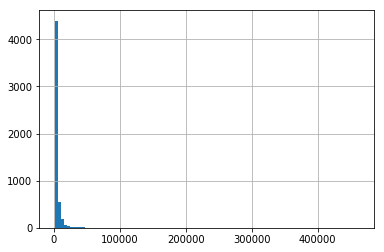

In [29]:
senate[senate['retweet_count'] > 1000].retweet_count.hist(bins=100)

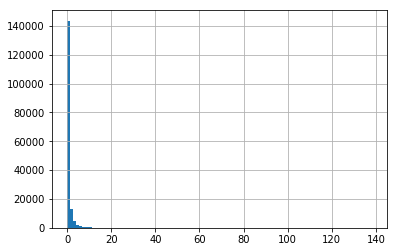

In [30]:
senate[senate['the_ratio'] > 0 ].the_ratio.hist(bins=100)

In [31]:
senate.describe()

,id_str,reply_count,retweet_count,the_ratio
count,2.195390e+05,219539.000000,219539.000000,219539.000000
mean,6.517680e+17,24.766652,137.181412,0.677336
std,1.866934e+17,149.311035,1608.016919,1.847231
min,2.299999e+09,0.000000,1.000000,0.000000
25%,5.637520e+17,1.000000,3.000000,0.046512
50%,7.054430e+17,2.000000,7.000000,0.250000
75%,7.940000e+17,9.000000,22.000000,0.636364
max,8.666520e+17,14230.000000,462572.000000,138.000000


In [32]:
senate['z'] = np.log1p(senate.the_ratio)

In [33]:
senate.head()

,created_at,id_str,reply_count,retweet_count,text,user,name,state,party,the_ratio,z
0,Sun May 21 19:26:26 +0000 2017,8.660000e+17,116.0,174.0,"Franni here. Since it's Al's birthday, and sin...",alfranken,Al Franken,New York,Democratic,0.666667,0.510826
1,Tue May 16 01:44:44 +0000 2017,8.640000e+17,718.0,1248.0,This is profoundly troubling. Why would Presid...,alfranken,Al Franken,New York,Democratic,0.575321,0.454459
2,Wed May 10 19:55:37 +0000 2017,8.620000e+17,218.0,1334.0,It couldn't be clearer: we need an independent...,alfranken,Al Franken,New York,Democratic,0.163418,0.151362
3,Wed May 10 19:54:55 +0000 2017,8.620000e+17,134.0,794.0,More troubling news: AG Sessions was involved ...,alfranken,Al Franken,New York,Democratic,0.168766,0.155948
4,Wed May 10 19:54:20 +0000 2017,8.620000e+17,131.0,556.0,Troubling news that you probably know by now: ...,alfranken,Al Franken,New York,Democratic,0.235612,0.211566


In [34]:
senate.sort_values('the_ratio', ascending=False).head()

,created_at,id_str,reply_count,retweet_count,text,user,name,state,party,the_ratio,z
11976,Fri Nov 25 03:48:06 +0000 2016,8.019960e+17,138.0,1.0,Most endearing family name for a grandmother?,BenSasse,Ben Sasse,Nebraska,Republican,138.000000,4.934474
155381,Thu Feb 02 18:24:16 +0000 2017,8.272210e+17,1505.0,11.0,Glad you stopped by @G_Dahlkemper https://t.co...,SenToomey,Pat Toomey,Pennsylvania,Republican,136.818182,4.925935
109263,Fri Feb 10 21:44:52 +0000 2017,8.301710e+17,108.0,1.0,Here’s what happened this week in the Senate: ...,SenatorIsakson,Johnny Isakson,Georgia,Republican,108.000000,4.691348
36978,Sat Jan 28 03:19:55 +0000 2017,8.251820e+17,193.0,2.0,Drake wins ovr UNI 88/79,ChuckGrassley,Chuck Grassley,Iowa,Republican,96.500000,4.579852
15547,Tue Feb 07 17:59:44 +0000 2017,8.290270e+17,96.0,1.0,About to go on @CNN to speak with @wolfblitzer...,BillCassidy,Bill cassidy,Louisiana,Republican,96.000000,4.574711


In [35]:
np.var(senate['the_ratio'])

3.4122469061637255

In [36]:
senate.the_ratio.mean()

0.6773362343539384

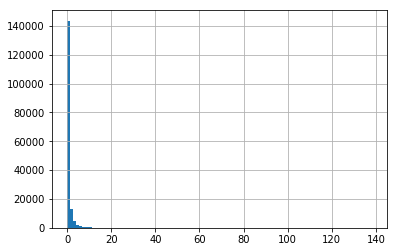

In [37]:
senate[senate['z'] > 0 ].the_ratio.hist(bins=100)

In [38]:
senate.z.mean()

0.36119891517670105

In [39]:
senate.z.var()

0.20235818469400238

Gamma dist:

mean = alpha*Beta

Variance = alpha*(Beta**2)

### Getting the ratio for Democrats and Republicans

In [41]:
the_ratio_dem = senate[senate['party'] =='Democratic'].the_ratio.values
the_ratio_rep = senate[senate['party'] =='Republican'].the_ratio.values

In [42]:
print(the_ratio_dem.mean(), the_ratio_dem.var())
print(the_ratio_rep.mean(), the_ratio_rep.var())

0.37668160435989506 0.7342832379182765
0.9539370092177968 5.682548775324917


<a id='freq-ttest'></a>
### Perform a Frequentist t-test of the mean the_ratio difference between groups.

In [43]:
tt = stats.ttest_ind(the_ratio_rep, the_ratio_dem)
print(tt.statistic)
print(tt.pvalue)

72.1505574553688
0.0


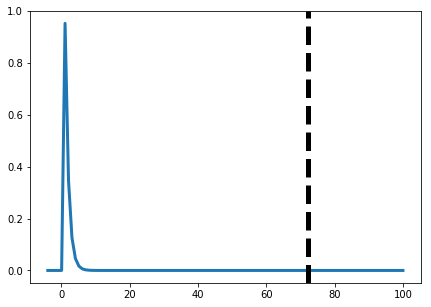

In [44]:
# THIS MAY OR MAYNOT BE USEFUL
zdist = stats.gamma(1,1)
xvals = np.linspace(-4, 100, 104)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(xvals, zdist.pdf(xvals), lw=3)
ax.axvline(tt.statistic, color='black', ls='dashed', lw=5)
plt.show()

<a id='priors'></a>
### Set up the bayesian model with priors on mean APMs

Next we'll go through the steps of the Bayesian estimation of the difference between means using `pymc3`.

First we find the mean and standard deviation of the_ratio regardless of partisanship. We can going to use these values to inform our prior belief about the_ratio.

In [45]:
prior_mean = senate.the_ratio.mean()
prior_std = senate.the_ratio.std()

print(prior_mean, prior_std)

0.6773362343539384 1.847231022102251


In [56]:
with pm.Model() as model:
    dem_mean = pm.Gamma('ratio_dem_mean', 
                               alpha = 0.134, 
                               beta = 5.039)
    rep_mean = pm.Gamma('ratio_rep_mean', 
                               alpha = 0.134, 
                               beta = 5.039)

In [57]:
# A: P(mu_apm, std_apm)
prior_std_lower = 0.000001
prior_std_upper = 100.0

with model:
    dem_std = pm.Uniform('ratio_dem_std',
                          lower=prior_std_lower,
                          upper=prior_std_upper)
    rep_std = pm.Uniform('ratio_rep_std',
                          lower=prior_std_lower,
                          upper=prior_std_upper)

In [52]:
# A: P(data | mu, std)
with model:
    dem = pm.Gamma('ratio_dem_like',
                    observed = the_ratio_dem,
                    alpha = 0.514,
                    beta = 1.940)
    rep = pm.Gamma('ratio_rep_like',
                    observed = the_ratio_rep,
                    alpha = 0.168,
                    beta = 5.957)

In [58]:
with model:
    diff_of_means = pm.Deterministic('mean_diff',
                                      rep_mean - dem_mean)
    diff_of_std = pm.Deterministic('std_diff',
                                    rep_std - dem_std)

In [59]:
# A:
with model:
    trace = pm.sample_approx(10000)

AttributeError: 'int' object has no attribute 'sample'

In [60]:
### nump.log1p - transform the ratio into 

## mean and variance of Z (new target variabe)

In [22]:
z_dem = senate[senate['party'] =='Democratic'].z.values
z_rep = senate[senate['party'] =='Republican'].z.values

print('Democrat', z_dem.mean(), z_dem.var())
print('Republican', z_rep.mean(), z_rep.var())

Democrat 0.25661434708288705 0.09123438607177879
Republican 0.4588512619374477 0.28339384664220113


In [55]:
tt = stats.ttest_ind(z_rep, z_dem)
print(tt.statistic)
print(tt.pvalue)

105.64033822739268
0.0
